In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import optimize
from tqdm import tqdm
from multiprocess import Pool

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4
from utility import log_mesh
from free_solutions import phase_shift, phase_shift_interp
from mottmassey import mm_potential

plt.style.use('science')
ratio = 4/3
h = 3

In [2]:
def wave_function(v_r, energy, r_endpts=np.array([1e-2, 2000])):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-9, atol=1e-12,
        dense_output=True, method='DOP853'
    )
    return sol.sol


def delta(v_r, energy, r_match=300):
    k = np.sqrt(2*MU*energy)
    sol = wave_function(v_r, energy)
    
    delta_0 = np.random.rand()
    rel_diff = 1
    
    while rel_diff > 1e-5:
        r = np.linspace(0.99*r_match, 1.01*r_match, 100)
        rho = k*r
        u, _ = sol(r)
        delta_1 = phase_shift_interp(u, rho, 0, k*r_match).real
        
        rel_diff = np.abs((delta_1 - delta_0)/delta_0)
        delta_0 = delta_1
        r_match *= 1.1
    
    return delta_1, r_match/1.1

In [3]:
ks = np.hstack(
    (np.logspace(np.log10(0.1/BETA4), np.log10(10/BETA4), 50),
     np.linspace(10.1/BETA4, 100/BETA4, 50))
)
energies = ks**2/(2*MU)

In [4]:
pot = mm_potential

In [5]:
%%time
delta(pot, energies[0])

CPU times: user 15.6 ms, sys: 3.07 ms, total: 18.7 ms
Wall time: 18.8 ms


(0.1782330054338038, 1035.681364317931)

In [6]:
%%time
deltas = np.array([delta(pot, en)[0] for en in energies])

CPU times: user 39.7 s, sys: 94.3 ms, total: 39.8 s
Wall time: 39.8 s


/Users/danielodell/XH-scattering/free_solutions.py:80: RuntimeWarning: divide by zero encountered in true_divide
  rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
/Users/danielodell/XH-scattering/free_solutions.py:82: RuntimeWarning: invalid value encountered in multiply
  (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) /
/Users/danielodell/XH-scattering/free_solutions.py:83: RuntimeWarning: invalid value encountered in multiply
  (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))


In [7]:
ks.shape, deltas.shape

((100,), (100,))

In [8]:
deltas_mm = np.loadtxt('phase_shifts_mott_massey_wide_dense.txt')
ks_mm = deltas_mm[:, 0]
deltas_mm = deltas_mm[:, 1]

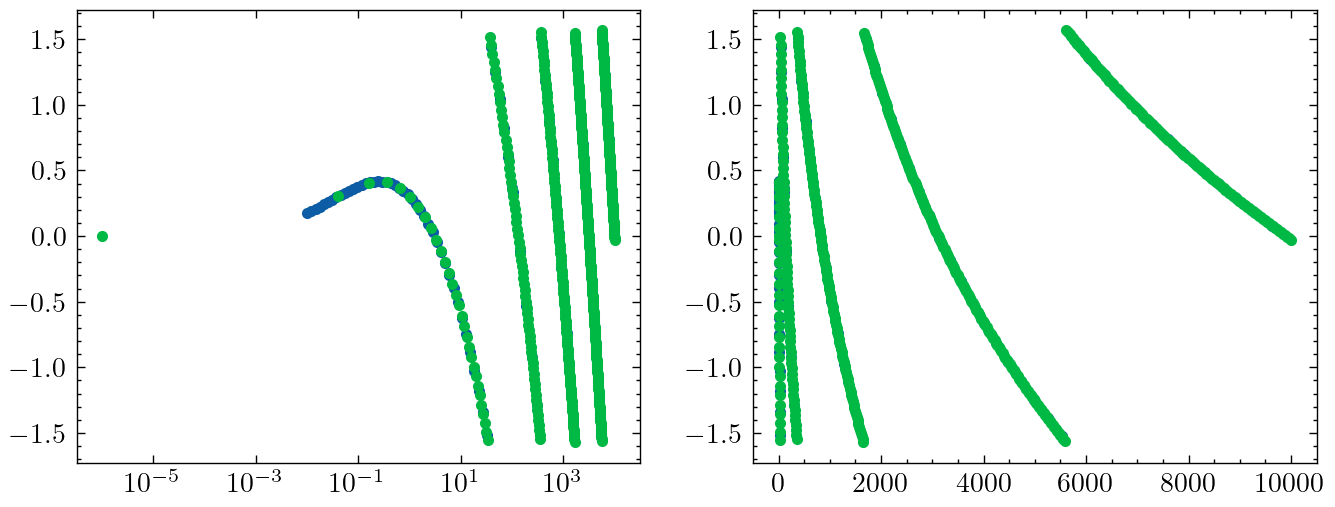

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('white')

ax[0].scatter((ks*BETA4)**2, deltas, marker='.')
ax[0].scatter((ks_mm*BETA4)**2, deltas_mm, marker='.')
ax[1].scatter((ks*BETA4)**2, deltas, marker='.')
ax[1].scatter((ks_mm*BETA4)**2, deltas_mm, marker='.')

ax[0].set_xscale('log');

In [10]:
np.savetxt('phase_shifts_mott_massey_wide_dense_coord_ir_corrected.txt', np.vstack((ks, deltas)).T)

In [83]:
# bad_energies = np.where(np.isnan(deltas))[1]

# good_deltas = np.delete(deltas, bad_energies, axis=1)
# good_ks = np.delete(ks, bad_energies)

# np.savetxt('phase_shifts_mott_massey_wide_dense_coord_ir_corrected.txt', np.vstack((good_ks, good_deltas)).T)